# Clustering on Amazon Fine FOod Reviews

In [1]:
#importing necessary packages
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
import sqlite3
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
import pickle
import sklearn.cross_validation
from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import cross_validation
from sklearn.metrics import precision_score,recall_score,f1_score,confusion_matrix,roc_auc_score,roc_curve


C:\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Reading already Cleaned, Preprocessed data from database

After removing stopwords, punctuations, meaningless characters, HTML tags from Text 
and done stemming. Using it directly as it was alredy done in prevoius assignment

In [2]:
#Reading
conn= sqlite3.connect('cleanedTextData.sqlite')
data= pd.read_sql_query('''
SELECT * FROM Reviews
''',conn)
data=data.drop('index',axis=1)
data.shape

(364171, 11)

In [3]:
data.columns

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text',
       'CleanedText'],
      dtype='object')

In [4]:
data['CleanedText'].head(3)

0    witti littl book make son laugh loud recit car...
1    rememb see show air televis year ago child sis...
2    beetlejuic well written movi everyth act speci...
Name: CleanedText, dtype: object

In [ ]:
def wordCloud(clusterPerReview,reviewText,k):
    '''
    Prints  wordclouds of all the clusters given cluster number per review and review text
    '''
    clusterGroup={}
    i=0
    for c in clusterPerReview:
        if c in clusterGroup.keys():
            clusterGroup[c]+= reviewText[i]
        else:
            clusterGroup[c]=reviewText[i]
        i+=1
    print('So we have',k,'clusters here representing in wordcloud:')
    for i in list(set(cluster)):
        print('Cluster Number',i+1,':')
        plt.figure()
        plt.imshow(WordCloud().generate(clusterGroup[i]))
        plt.axis("off")

# Kmeans

 ## Sorting on the basis of 'Time' and taking top 50k pts

 This data has time attribute so it will be reasonable to do time based splitting instead
   of random splitting.

 So, before splitting we have to sort our data according to time and here we are taking
 50k points from our dataset(population)

In [5]:
data["Time"] = pd.to_datetime(data["Time"], unit = "ms")
data = data.sort_values(by = "Time")

In [6]:
#latest 50k points according to time
Xdata1= data[:50000]['CleanedText']
len(Xdata1)

50000

In [137]:
from sklearn.cluster import KMeans
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline

def optimalKmeans(Xdata):
    param_K = [2,3,4,5,6,7,8]
    inertia={}
    for K in param_K:
        model= KMeans(n_clusters=K, init= 'k-means++', precompute_distances= True, n_jobs= -1)
        model.fit(Xdata)
        inertia[K]= model.inertia_
    plt.plot(list(inertia.keys()), list(inertia.values()))
    plt.xlabel("No. of cluster")
    plt.ylabel("Inertia")
    plt.show()
    bestK= min(inertia, key=inertia.get)
    print('The best K according to min inertia is ',bestK)
    return bestK


---
# Kmeans: BOW Vectorization
Bow vectorization is basic technique to convert a text into numerical vector.
* We will build a model on train text using fit-transform

In [8]:
# vectorizing X and transforming
bowModel1=CountVectorizer()
XdataBOWV1=bowModel1.fit_transform(Xdata1)
XdataBOWV1.shape

(50000, 32970)

In [9]:
#Standardizing vectors
XdataBOWV1 = StandardScaler(with_mean=False).fit_transform(XdataBOWV1)

C:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


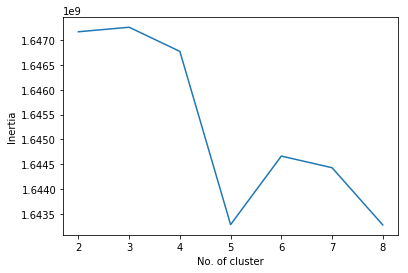

The best K according to min inertia is  8


In [10]:
k= optimalKmeans(XdataBOWV1)

In [199]:
BOWkm = KMeans(n_clusters=k, init= 'k-means++', precompute_distances= True, n_jobs= -1)
cluster= list(BOWkm.fit_predict(XdataBOWV1))

So we have 8 clusters here representing in wordcloud:
Cluster Number 1 :
Cluster Number 2 :
Cluster Number 3 :
Cluster Number 4 :
Cluster Number 5 :
Cluster Number 6 :
Cluster Number 7 :
Cluster Number 8 :


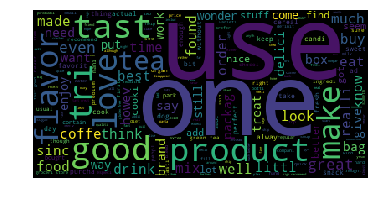

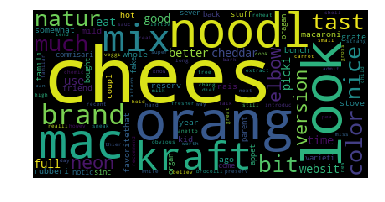

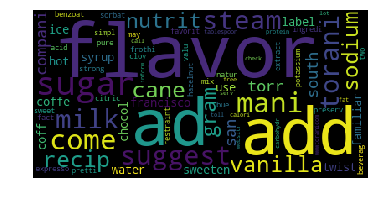

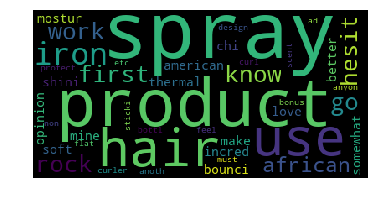

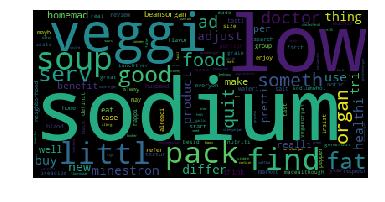

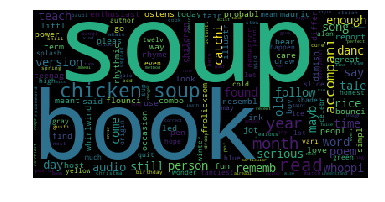

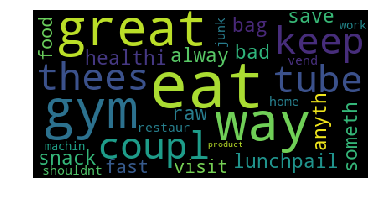

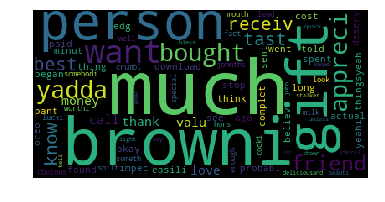

In [201]:
wordCloud(cluster,list(Xdata1),8)

## Observations:-
* **Cluster 1 :-** This cluster has major words as how poeple feel about food :- good, well, lot, little, love, tasty, wonderful, flavor etc
* **Cluster 2 :-** This cluster has major words as of chinease food:- noodle, macaroni, cheese etc
* **Cluster 3 :-** This cluster has major words from sweet and milk made products:- milk, chocolate, vanilla, sugar, coffee, syrup
* **Cluster 4 :-** This cluster has major words not so related to food stuffs like:- spray, hair, bouncy, iron, rock etc
* **Cluster 5 :-** This cluster has major words as nutrition like:- sodium, fat, veggi, homemade, high, low, little etc
* **Cluster 6 :-** This cluster has major words as liquid items:- chicken soup, hot etc
* **Cluster 7 :-** This cluster has no major distinction but has something to do with gym, fittness 
* **Cluster 8 :-** This cluster has major words as dilevery:- want, bought, recived, gift


***
# Kmeans: TFIDF vectorization

* We will build a model on train text using fit-transform
* Then transform (test) text on model build by train text
* Transformed data will be in the form of sparse matrix

In [12]:
# generating vetor out of text using tfidf
tfidfModel1=TfidfVectorizer()
XdataTFIDFV1= tfidfModel1.fit_transform(Xdata1)

In [13]:
#Standardizing vectors
XdataTFIDFV1 = StandardScaler(with_mean=False).fit_transform(XdataTFIDFV1)

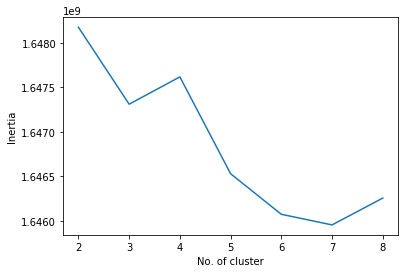

The best K according to min inertia is  7


In [14]:
k= optimalKmeans(XdataTFIDFV1)

In [15]:
TFIDFkm = KMeans(n_clusters=k, init= 'k-means++', precompute_distances= True, n_jobs= -1)
cluster= list(TFIDFkm.fit_predict(XdataTFIDFV1))

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=7, n_init=10, n_jobs=-1, precompute_distances=True,
    random_state=None, tol=0.0001, verbose=0)

So we have 7 clusters here representing in wordcloud:
Cluster Number 1 :
Cluster Number 2 :
Cluster Number 3 :
Cluster Number 4 :
Cluster Number 5 :
Cluster Number 6 :
Cluster Number 7 :


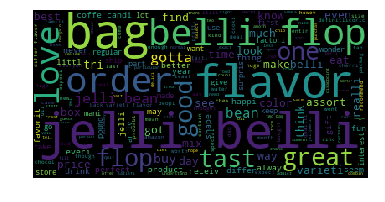

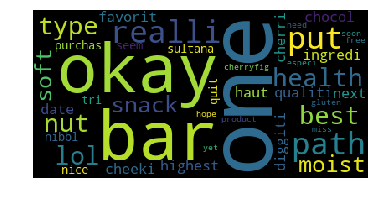

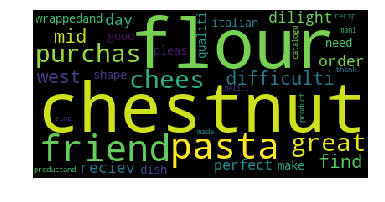

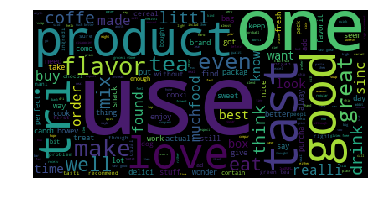

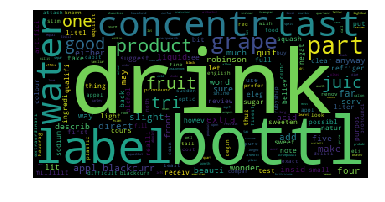

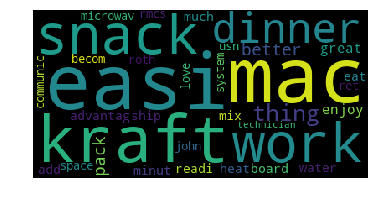

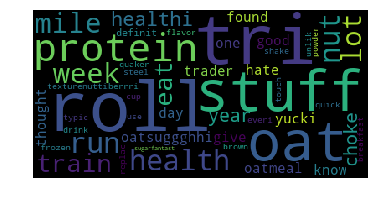

In [60]:
wordCloud(cluster,list(Xdata1),7)

## Observations:-
* **Cluster 1 :-** This cluster has major words from candy:- jelly, jelly belly, jelly bean
* **Cluster 2 :-** This cluster has major words chocolate:- chocolate bar, with nut, snack etc
* **Cluster 3 :-** This cluster has major words from itallian:- pasta, cheese, italian, flour
* **Cluster 4 :-** This cluster has major words from coffee:- coffee, tea, hot, drink etc
* **Cluster 5 :-** This cluster has major words as juice:- grape, fruit, bottle, drink, water, concentration etc
* **Cluster 6 :-** This cluster has no major distinction but has something to do with snack and dinner
* **Cluster 7 :-** This cluster has major words from nutrition:- protein, oat, oatmeal, healthy, nuts etc


# Kmeans: Avg W2V vectorization

In [16]:
import gensim
# training our gensim model on our train text
import re
import string
def cleanhtml(sentance): #substitute expression contained in <> with ' '
    cleaned= re.sub(re.compile('<.*?>'),' ',sentance)
    return cleaned
#function for removing punctuations chars
def cleanpunc(sentance):
    cleaned= re.sub(r'[?|!|\'|"|#]',r'',sentance)
    cleaned= re.sub(r'[.|,|)|(|\|/]',r'',sentance)
    return cleaned
i=0
lists=[]

for sent in Xdata1.values:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue
    lists.append(filtered_sentence)


w2v_model= gensim.models.Word2Vec(lists,min_count=5,size=50,workers=4)
print(len(list(w2v_model.wv.vocab)))

C:\Anaconda3\lib\site-packages\gensim\utils.py:1209: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


8991


In [17]:
w2v_words = list(w2v_model.wv.vocab)

In [18]:
# converting list of sentance into list of list of words
# then to vector using avg w2v
# function to convert list of list of words to vect using avg w2v
def w2vVect(X):
    '''
    This function takes list of sentance as input (X) and convert it into 
    list of list of words and then feed it into our gensim model to get vector
    and then take its average, finally returns sent_vectors(vector of sentance)
    *************GENSIM MODEL WAS TRAINED ON TRAINDATA***************
    '''

    lists=[]
    for sent in X.values:
        filtered_sentence=[]
        sent=cleanhtml(sent)
        for w in sent.split():
            for cleaned_words in cleanpunc(w).split():
                if(cleaned_words.isalpha()):
                    filtered_sentence.append(cleaned_words.lower())
                else:
                    continue
        lists.append(filtered_sentence)

    sent_vectors = []; 
    for sent in lists: 
        sent_vec = np.zeros(50) 
        cnt_words =0;
        for word in sent: 
            if word in w2v_words:
                vec = w2v_model.wv[word]
                sent_vec += vec
                cnt_words += 1
        if cnt_words != 0:
            sent_vec /= cnt_words
        sent_vectors.append(sent_vec)
    return sent_vectors

In [19]:
# Vectorizing our data
XdataW2VV1= w2vVect(Xdata1)

In [20]:
#Standardizing vectors
XdataW2VV1 = StandardScaler(with_mean=False).fit_transform(XdataW2VV1)

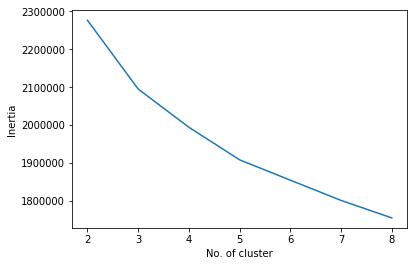

The best K according to min inertia is  8


In [21]:
k= optimalKmeans(XdataW2VV1)

In [63]:
W2Vkm = KMeans(n_clusters=k, init= 'k-means++', precompute_distances= True, n_jobs= -1)
cluster= list(W2Vkm.fit_predict(XdataW2VV1))

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=8, n_init=10, n_jobs=-1, precompute_distances=True,
    random_state=None, tol=0.0001, verbose=0)

So we have 8 clusters here representing in wordcloud:
Cluster Number 1 :
Cluster Number 2 :
Cluster Number 3 :
Cluster Number 4 :
Cluster Number 5 :
Cluster Number 6 :
Cluster Number 7 :
Cluster Number 8 :


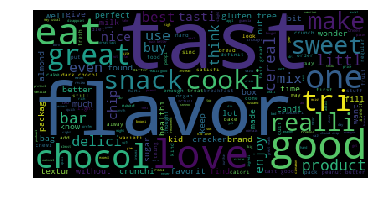

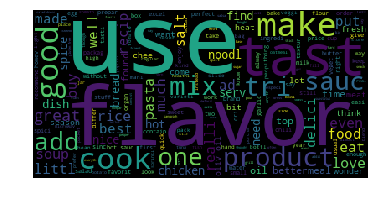

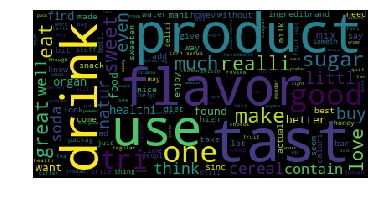

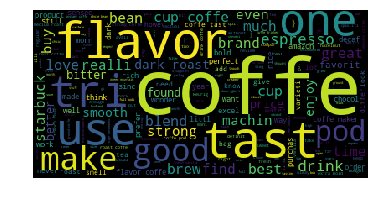

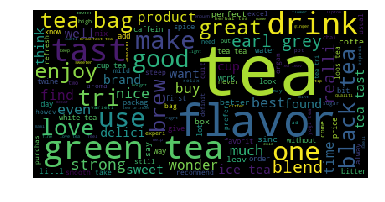

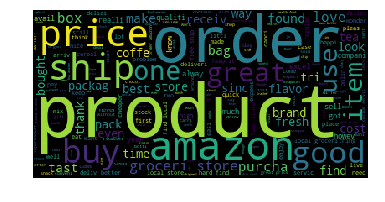

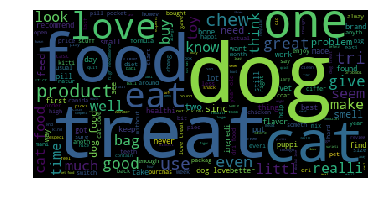

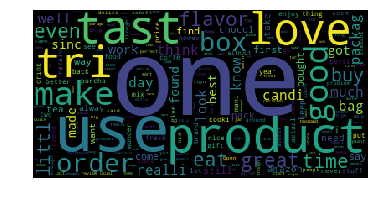

In [93]:
wordCloud(cluster,list(Xdata1),8)

## Observations:-
* **Cluster 1 :-** This cluster has major words from sweet:- snack, cookie, chocolate, bar etc
* **Cluster 2 :-** This cluster has major words chinease:- sauce, noodle, pasta, salt
* **Cluster 3 :-** This cluster has major words from drinks
* **Cluster 4 :-** This cluster has major words from coffee:- tea bag, tea, hot, drink, green tea, blended etc
* **Cluster 5 :-** This cluster has major words from tea:- coffee, tea, hot, drink etc
* **Cluster 6 :-** This cluster has major words as dilevery:- amazon, order, shippment, delivery, bought, recived, gift
* **Cluster 7 :-** This cluster has major words from animal food:- dog, cat, chew etc
* **Cluster 8 :-** This cluster has major words as how poeple feel about food :- good, well, lot, little, love, tasty, wonderful, flavor etc

# Kmeans: TFIDF-weighted avg W2V vectorization

In [23]:
tfmodel=TfidfVectorizer(max_features=2000)
tf_idf_matrix = tfmodel.fit_transform(Xdata1.values)
tfidf_feat=tfmodel.get_feature_names()
dictionary = {k:v for (k,v) in zip(tfmodel.get_feature_names(), list(tfmodel.idf_))}

In [24]:
def tfidfw2vVect(X):
    '''
    This function converts list of sentance into list of list of words and then 
    finally applies average-tfidf-w2w to get final sentance vector
    w2v model and w2v words already made during w2v vectorization part 
    '''
    lists=[]
    for sent in X.values:
        filtered_sentence=[]
        sent=cleanhtml(sent)
        for w in sent.split():
            for cleaned_words in cleanpunc(w).split():
                if(cleaned_words.isalpha()):
                    filtered_sentence.append(cleaned_words.lower())
                else:
                    continue
        lists.append(filtered_sentence)
        
    tfidfw2v_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
    row=0;
    for sent in lists: # for each review/sentence 
        sent_vec = np.zeros(50) # as word vectors are of zero length
        weight_sum =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            try:
                if word in w2v_words:
                    vec = w2v_model.wv[word]
                    #tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
                    #to reduce the computation we are 
                    #dictionary[word] = idf value of word in whole courpus
                    #sent.count(word) = tf valeus of word in this review
                    tf_idf = (dictionary[word])*((sent.count(word))/len(sent))
                    sent_vec += (vec * tf_idf)
                    weight_sum += tf_idf
            except:
                pass
        if weight_sum != 0:
            sent_vec /= weight_sum
        tfidfw2v_sent_vectors.append(sent_vec)
        row += 1
    # converting nan and infinte values in vect to digit
    tfidfw2v_sent_vectors= np.nan_to_num(tfidfw2v_sent_vectors)
    return tfidfw2v_sent_vectors

In [25]:
# feeding text data and recieving vectorized data
XdataTFIDFW2VV1= tfidfw2vVect(Xdata1)

In [26]:
#Standardizing vectors
XdataTFIDFW2VV1 = StandardScaler(with_mean=False).fit_transform(XdataTFIDFW2VV1)

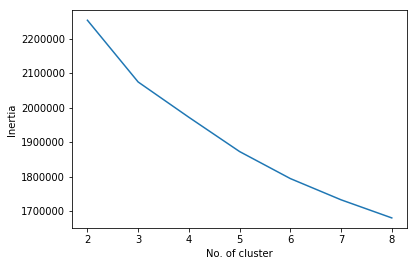

The best K according to min inertia is  8


In [27]:
k= optimalKmeans(XdataTFIDFW2VV1)

In [28]:
TFIDFW2Vkm = KMeans(n_clusters=k, init= 'k-means++', precompute_distances= True, n_jobs= -1)
cluster= list(TFIDFW2Vkm.fit_predict(XdataTFIDFW2VV1))

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=8, n_init=10, n_jobs=-1, precompute_distances=True,
    random_state=None, tol=0.0001, verbose=0)

So we have 8 clusters here representing in wordcloud:
Cluster Number 1 :
Cluster Number 2 :
Cluster Number 3 :
Cluster Number 4 :
Cluster Number 5 :
Cluster Number 6 :
Cluster Number 7 :
Cluster Number 8 :


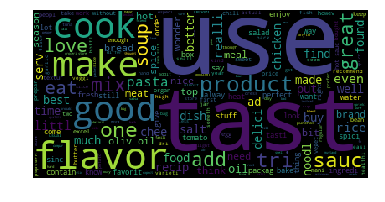

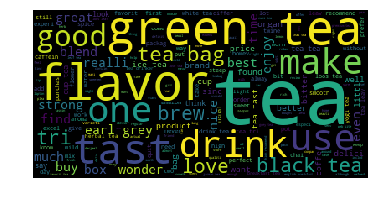

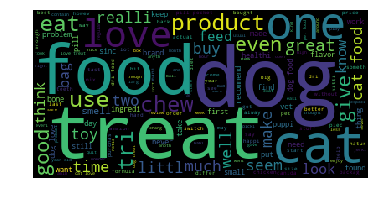

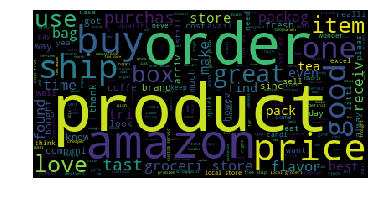

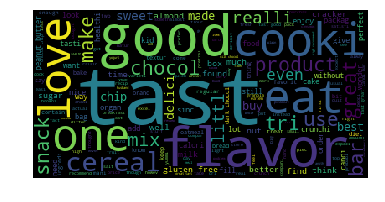

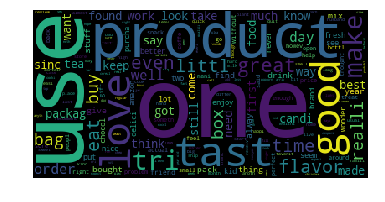

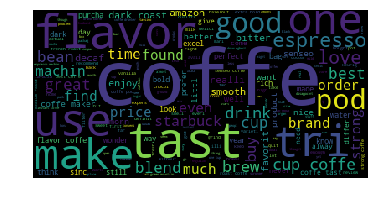

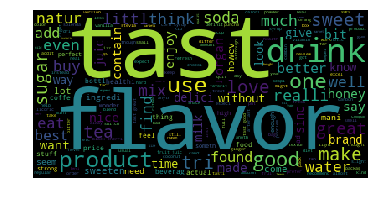

In [94]:
wordCloud(cluster,list(Xdata1),8)

## Observations:-
* **Cluster 1 :-** This cluster has major words as liquid items:- chicken soup, hot, oil etc
* **Cluster 2 :-** This cluster has major words from tea:- coffee, tea, green tea, black tea, hot, drink etc
* **Cluster 3 :-** This cluster has major words from animal food:- dog, cat, chew etc
* **Cluster 4 :-** This cluster has major words as dilevery:- amazon, order, shippment, delivery, bought, recived, gift
* **Cluster 5 :-** This cluster has no distinction but have something to do with flavour
* **Cluster 6 :-** This cluster has no distinction but have something to do with product
* **Cluster 7 :-** This cluster has major words from coffee:- tea bag, tea, hot, drink, green tea, blended, brew, starbucks etc 
* **Cluster 8 :-** This cluster has major words liquid:- honey, tea, soda, syrup etc


======================================================================================
# Agglomerative Clustering

In [95]:
from sklearn.cluster import AgglomerativeClustering

### Taking sample of 4000 pts from the corpus

In [29]:
#latest 4k points according to time
Xdata2= data[:4000]['CleanedText']
len(Xdata2)

4000

## Agglomerative: W2V Vectorization

In [30]:
# Vectorizing our data
XdataW2VV2= w2vVect(Xdata2)

In [31]:
#Standardizing vectors
XdataW2VV2 = StandardScaler(with_mean=False).fit_transform(XdataW2VV2)

In [194]:
W2V2aglo= AgglomerativeClustering(n_clusters=7)
cluster= list(W2V2aglo.fit_predict(XdataW2VV2))

So we have 5 clusters here representing in wordcloud:
Cluster Number 1 :
Cluster Number 2 :
Cluster Number 3 :
Cluster Number 4 :
Cluster Number 5 :
Cluster Number 6 :
Cluster Number 7 :


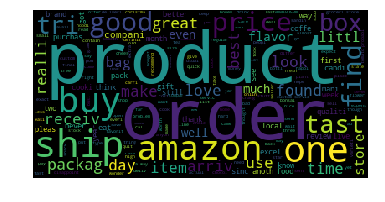

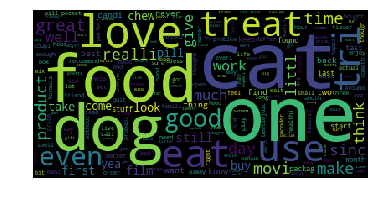

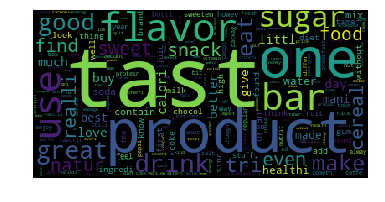

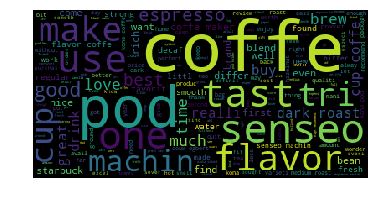

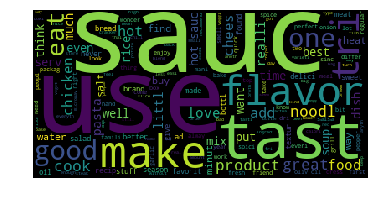

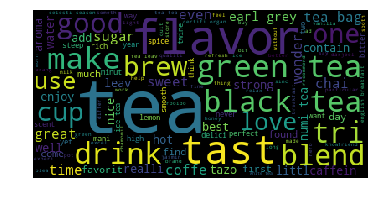

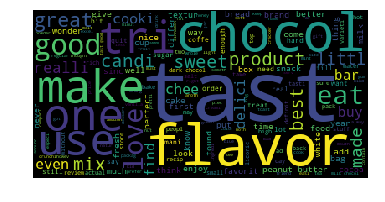

In [195]:
wordCloud(cluster,list(Xdata2), 7)

## Observations:-
* **Cluster 1 :-** This cluster has major words as dilevery:- amazon, order, shippment, delivery, bought, recived, gift
* **Cluster 2 :-** This cluster has major words from animal food:- dog, cat, chew etc
* **Cluster 3 :-** This cluster has major words as sweet item:- bar, cocolate, cereal, sugar etc
* **Cluster 4 :-** This cluster has major words from coffee:- hot, drink,  espresso, cup, blended, brew etc
* **Cluster 5 :-** This cluster has major words chinease:- sauce, noodle, pasta, salt, chicken etc
* **Cluster 6 :-** This cluster has major words from tea:- tea, green tea, black tea, hot, drink, blend, tea bag  etc
* **Cluster 7 :-** This cluster has major words from chocolate:- chocolate, bar, candy, sweet, nut  etc

## Agglomerative: TFIDF Weighted W2V Vectorization

In [32]:
# feeding text data and recieving vectorized data
XdataTFIDFW2VV2= tfidfw2vVect(Xdata2)

In [33]:
#Standardizing vectors
XdataTFIDFW2VV2 = StandardScaler(with_mean=False).fit_transform(XdataTFIDFW2VV2)

In [196]:
TFIDFW2VV2aglo= AgglomerativeClustering(n_clusters=7)
cluster= list(TFIDFW2VV2aglo.fit_predict(XdataTFIDFW2VV2))

So we have 7 clusters here representing in wordcloud:
Cluster Number 1 :
Cluster Number 2 :
Cluster Number 3 :
Cluster Number 4 :
Cluster Number 5 :
Cluster Number 6 :
Cluster Number 7 :


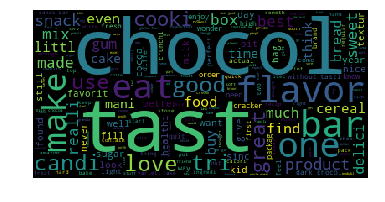

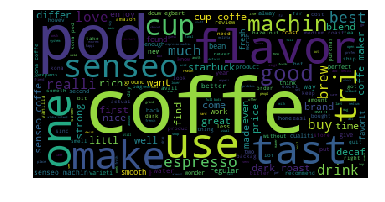

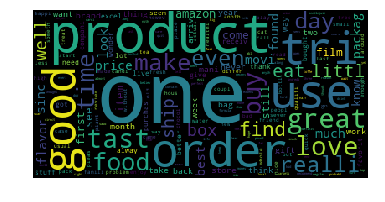

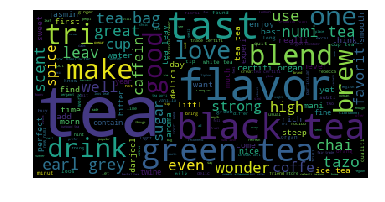

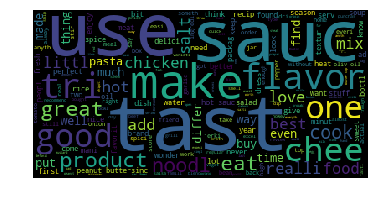

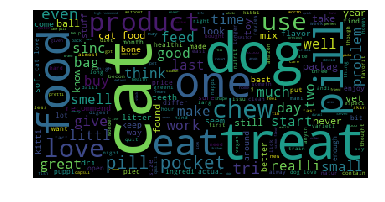

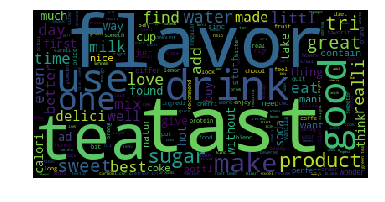

In [197]:
wordCloud(cluster,list(Xdata2),7)

## Observations:-
* **Cluster 1 :-** This cluster has major words from chocolate:- chocolate, bar, candy, sweet, nut  etc
* **Cluster 2 :-** This cluster has major words from coffee:- hot, drink,  espresso, cup, blended, brew etc
* **Cluster 3 :-** This cluster has major words as dilevery:- amazon, order, shippment, delivery, bought, recived, gift
* **Cluster 4 :-** This cluster has major words from tea:- tea, green tea, black tea, hot, drink, blend, tea bag  etc
* **Cluster 5 :-** This cluster has major words chinease:- sauce, noodle, pasta, salt, chicken etc
* **Cluster 6 :-** This cluster has major words from animal food:- dog, cat, chew etc
* **Cluster 7 :-** This cluster has major words as drinks:- milk, coke, soda, mix etc

======================================================================================
# DBSCAN

In [161]:
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
def NNforEPS(XdataVec,nn):
    '''
    performs elbow method and plots the curve after calculating nearest neighbors in vectors
    '''
    knn = NearestNeighbors(n_neighbors = nn, n_jobs= -1)
    knn.fit(XdataVec)
    dist , _ = knn.kneighbors(XdataVec)
    sort = sorted(dist[:,nn-1])
    plt.plot(list(range(1,len(XdataVec)+1)),sort,'r-')
    plt.xlabel('n_samples')
    plt.ylabel('Distance')
    plt.title('elbow method for finding eps')
    plt.grid()
    plt.show()

### Getting 4000 data from data corpus

In [34]:
#latest 4k points according to time
Xdata3= data[:4000]['CleanedText']
len(Xdata3)

4000

## DBSCAN: W2V Vectorization

In [35]:
# Vectorizing our data
XdataW2VV3= w2vVect(Xdata3)

In [36]:
#Standardizing vectors
XdataW2VV3 = StandardScaler(with_mean=False).fit_transform(XdataW2VV3)

#### Elbow method

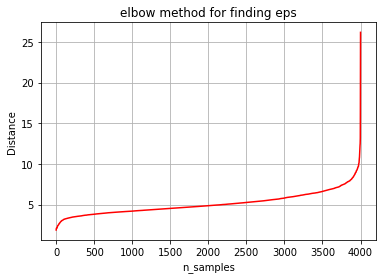

In [193]:
NNforEPS(XdataW2VV3,10)

In [191]:
W2Vdbscan= DBSCAN(eps=3.5, min_samples=10, n_jobs=-1)
cluster= list(W2Vdbscan.fit_predict(XdataW2VV3))

So we have 7 clusters here representing in wordcloud:
Cluster Number 1 :
Cluster Number 2 :
Cluster Number 3 :
Cluster Number 4 :
Cluster Number 5 :
Cluster Number 6 :
Cluster Number 0 :


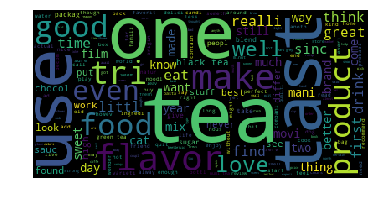

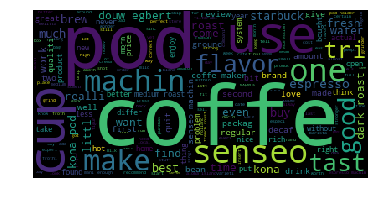

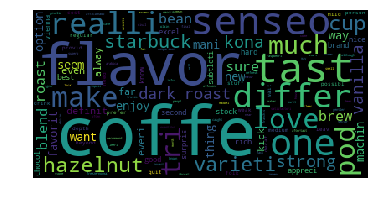

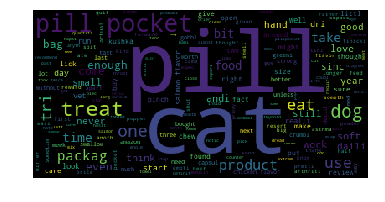

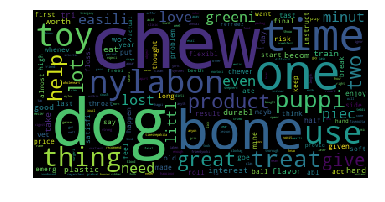

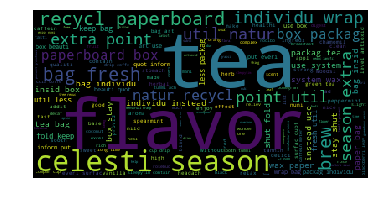

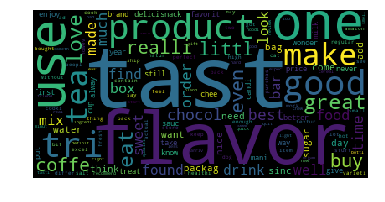

In [192]:
wordCloud(cluster,list(Xdata3),len(set(cluster)))

## Observations:-
* **Cluster 1 :-** This cluster has major words from tea:- tea, green tea, black tea, hot
* **Cluster 2 :-** & **Cluster 3 :-** This cluster has major words from coffee:- hot, drink,  espresso, cup, blended, brew etc
* **Cluster 4 :-** & **Cluster 5 :-** This cluster has major words from animal food:- dog, cat, chew etc
* **Cluster 6 :-** This cluster has major words from tea:- tea, green tea, black tea, hot, drink, blend, tea bag  etc
* **Cluster 7 :-** This cluster has major words as drinks:- milk, chocolate, soda, tea, coffe etc


## DBSCAN: TFIDF Weighted W2V Vectorization

In [37]:
# feeding text data and recieving vectorized data
XdataTFIDFW2VV3= tfidfw2vVect(Xdata3)

In [38]:
#Standardizing vectors
XdataTFIDFW2VV3 = StandardScaler(with_mean=False).fit_transform(XdataTFIDFW2VV3)

#### Elbow method

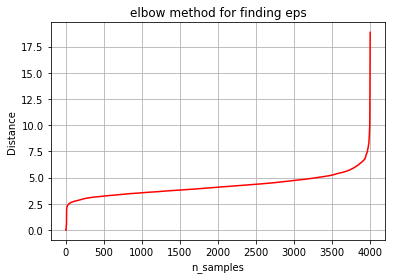

In [167]:
NNforEPS(XdataTFIDFW2VV3,5)

In [168]:
TFIDFW2Vdbscan= DBSCAN(eps=4, min_samples=5, n_jobs=-1)
cluster= list(TFIDFW2Vdbscan.fit_predict(XdataTFIDFW2VV3))

So we have 12 clusters here representing in wordcloud:
Cluster Number 1 :
Cluster Number 2 :
Cluster Number 3 :
Cluster Number 4 :
Cluster Number 5 :
Cluster Number 6 :
Cluster Number 7 :
Cluster Number 8 :
Cluster Number 9 :
Cluster Number 10 :
Cluster Number 11 :
Cluster Number 0 :


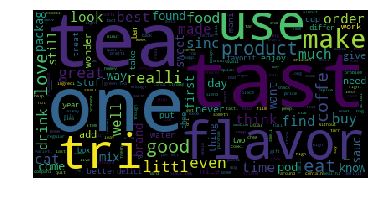

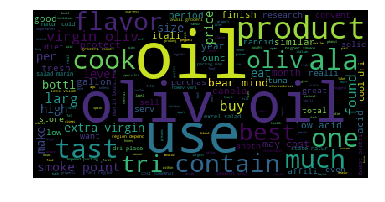

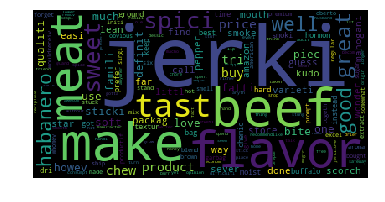

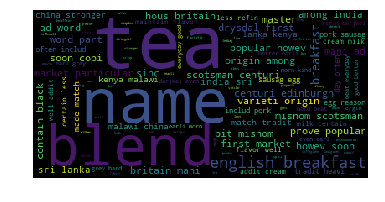

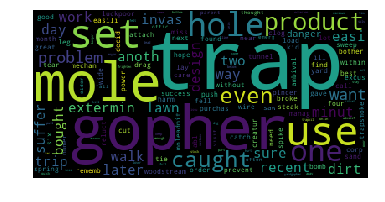

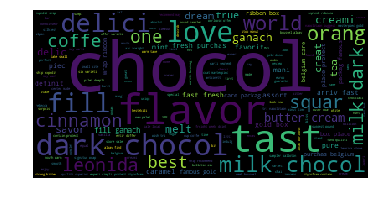

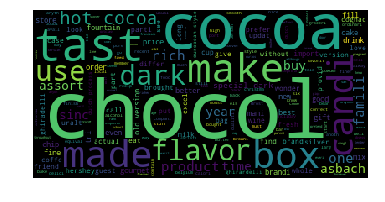

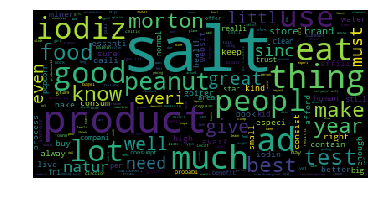

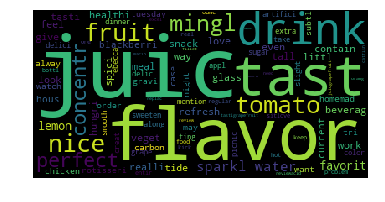

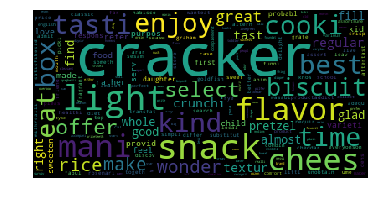

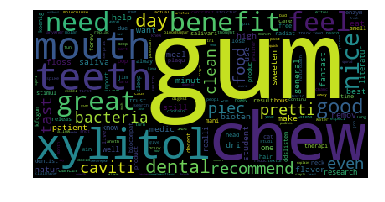

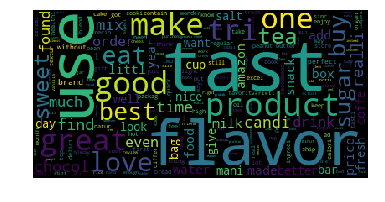

In [169]:
wordCloud(cluster,list(Xdata3),len(set(cluster)))

## Observations:-
* **Cluster 1 :-** & **Cluster 4 :-** This cluster has major words from tea:- tea, green tea, black tea, hot, drink, blend, tea bag  etc
* **Cluster 2 :-** This cluster has major words from oil:- olive oil, extravrgin oil, smoke point  etc
* **Cluster 3 :-** This cluster has major words from meat:- jerky, meat, beef etc
* **Cluster 5 :-** This cluster has major words from  trap :- food to get animal from lawn in trap  etc
* **Cluster 6 :-** & **Cluster 7 :-** This cluster has major words from chocolate
* **Cluster 8 :-** This cluster has major words as salted peanuts
* **Cluster 9 :-** This cluster has major words as juice and drinks
* **Cluster 10 :-** This cluster has major words snacks:- biscuits, cookies, snacks, crunchy cracker etc
* **Cluster 11 :-** This cluster has major words as chewing gums
* **Cluster 12 :-** This cluster has no major distinction but something related to flavour of candy, drinks etc


# ----------------------------------------------------------------------------------------------------


### Observations
* Kmeans works well if time complexity is considered, otherwise DBSCAN does better
* DBSCAN is very slow for large data sets, in otherwise case we csn use Kmeans
* We got our best results in form of cluster in DBSCAN Clustering with TFIDF Weighted W2V Vectorization

In [39]:
print('end\n\n\n\n\n')

end





